In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

import gymnasium as gym
import numpy as np
from collections import deque

# Initialize Cliff Walking environment
env = gym.make("CliffWalking-v0")#,render_mode="human")

In [7]:
# Constants
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 20
MAX_STEPS = 1000
SOLVED_SCORE = -13  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Actor Network (Policy Network)
class Actor(nn.Module):
    def __init__(self, state_space, action_space):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

# Critic Network (Value Network)
class Critic(nn.Module):
    def __init__(self, state_space):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Correctly initialize state from environment
state = env.reset()[0]

# Initialize networks
actor = Actor(env.observation_space.n, env.action_space.n).to(DEVICE)
critic = Critic(env.observation_space.n).to(DEVICE)

# Initialize optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=0.01)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.01)

In [10]:
# Track scores
scores = []
recent_scores = deque(maxlen=100)

# Training loop
for episode in tqdm(range(NUM_EPISODES)):
    state = env.reset()[0]
    score = 0

    while True:
        state_tensor = torch.nn.functional.one_hot(torch.tensor(state), env.observation_space.n).float().to(DEVICE)
        
        # Actor selects action
        action_probs = actor(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
                
        # Take action in the environment
        next_state, reward, done, _ = env.step(action.item())[:4]
        score += reward

        # Convert to tensors
        next_state_tensor = torch.nn.functional.one_hot(torch.tensor(next_state), env.observation_space.n).float().to(DEVICE)
        reward_tensor = torch.tensor(reward, dtype=torch.float32).to(DEVICE)

        # Critic calculates value
        value = critic(state_tensor)
        next_value = critic(next_state_tensor) if not done else torch.tensor([0]).to(DEVICE)

        # Calculate TD error
        td_target = reward_tensor + DISCOUNT_FACTOR * next_value
        td_error = td_target - value

        # Actor loss
        actor_loss = -m.log_prob(action) * td_error.detach()

        # Critic loss (MSE)
        critic_loss = F.mse_loss(value, td_target.detach())

        # Backpropagation
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        actor_optimizer.step()
        critic_optimizer.step()

        if score < -MAX_STEPS:
            print("Score too low")
            break

        if done:
            print(state, next_state)
            break

        state = next_state

    # Append episode score
    scores.append(score)
    recent_scores.append(score)

    # Early stopping if solved score goal is met
    if np.mean(recent_scores) >= SOLVED_SCORE:
        print(f"Environment solved in episode {episode}")
        break
env.close()


  5%|▌         | 1/20 [00:23<07:27, 23.53s/it]

Score too low


 10%|█         | 2/20 [00:48<07:19, 24.41s/it]

Score too low


 15%|█▌        | 3/20 [01:22<08:10, 28.87s/it]

Score too low


 20%|██        | 4/20 [01:47<07:15, 27.23s/it]

Score too low


 25%|██▌       | 5/20 [02:12<06:36, 26.43s/it]

Score too low


 30%|███       | 6/20 [02:37<06:01, 25.83s/it]

Score too low


 35%|███▌      | 7/20 [03:01<05:30, 25.41s/it]

Score too low


: 

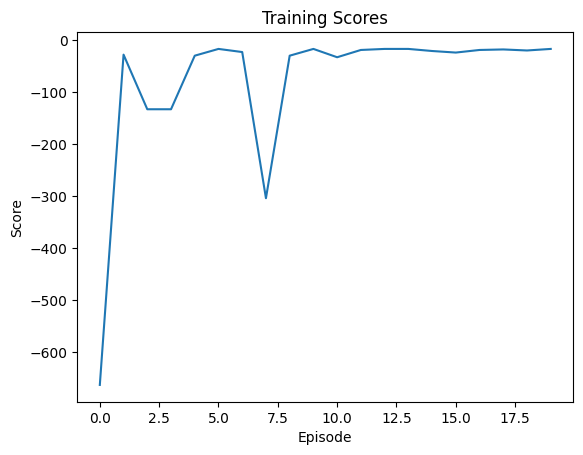

Total score: -17


In [ ]:
# Plot scores
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Training Scores")
plt.show()
print("Total score:", score)

In [ ]:
# Play Cliff Walking with trained model
# Initialize Cliff Walking environment
env = gym.make("CliffWalking-v0",render_mode="human")
state, _ = env.reset()
done = False
score = 0
while not done:
    state_tensor = torch.nn.functional.one_hot(torch.tensor(state), env.observation_space.n).float().to(DEVICE)
    action_probs = actor(state_tensor)
    action = torch.argmax(action_probs).item()
    next_state, reward, done, _ = env.step(action)[:4]
    score += reward
    env.render()

env.close()
print("Total score:", score)

: 